# **Point Net - Classification**

In [1]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3

from open3d.web_visualizer import draw # for non Colab
import os, os.path as osp

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
NUM_TRAIN_POINTS = 2500
NUM_TEST_POINTS = 10000
NUM_CLASSES = 16
GLOBAL_FEATS = 1024
BATCH_SIZE = 32
CATEGORIES = {
    'Airplane': 0, 
    'Bag': 1, 
    'Cap': 2, 
    'Car': 3,
    'Chair': 4, 
    'Earphone': 5, 
    'Guitar': 6, 
    'Knife': 7, 
    'Lamp': 8, 
    'Laptop': 9,
    'Motorbike': 10, 
    'Mug': 11, 
    'Pistol': 12, 
    'Rocket': 13, 
    'Skateboard': 14, 
    'Table': 15}
            
ROOT = osp.abspath("shapenet_like_out")

In [3]:
from torch.utils.data import DataLoader
from shapenet_dataset import ShapenetDataset

npoints = 10000
ROOT = osp.abspath("shapenet_like_out")
# test Dataset & DataLoader 
test_dataset = ShapenetDataset(ROOT, npoints=npoints, split='test', classification=True, normalize=False) #already normalized in convert_to_shapenet_like, see later if we keep it like that or not
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## Now: feature extraction of the foils

In [4]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import warnings
from point_net import PointNetClassHead
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm

def analyze_pointnet_backbone(
    MODEL_PATH: str,
    *,
    eps: float = 3.0,
    min_samples: int = 10,
    tsne_perplexity: float = 30.0,
    tsne_n_iter: int = 1000,
    tsne_learning_rate="auto",
    random_state: int = 42,
    gallery_per_cluster: int = 10,
    cmap_name: str = "tab20",
    cluster_cmap_name: str = "tab20"   # <— NEW: colormap for clusters
):
    """
    Load a PointNet classifier, extract backbone features on test_dataloader,
    visualize with t-SNE, cluster with DBSCAN, show small galleries per cluster,
    and plot t-SNE colored by DBSCAN clusters.
    """

    model_name = os.path.splitext(os.path.basename(MODEL_PATH))[0]

    # ------------------------------------------------------------------------------- Build and load model
    classifier = PointNetClassHead(
        num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES
    ).to(DEVICE)
    state = torch.load(MODEL_PATH, map_location=DEVICE)
    classifier.load_state_dict(state)
    classifier.eval()

    print(f"[{model_name}] Model loaded from: {MODEL_PATH}")

    # --- Extract global features from the backbone ---
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for pts, labels in test_dataloader:  # pts: (B,N,3)
            x = pts.transpose(2, 1).to(DEVICE)  # -> (B,3,N)
            gfeat, crit_idxs, _ = classifier.backbone(x)  # gfeat: (B,1024) usually
            gfeat = torch.nn.functional.normalize(gfeat, p=2, dim=1)  # optional L2
            all_feats.append(gfeat.cpu().numpy())
            all_labels.append(labels.squeeze(1).cpu().numpy())

    X = np.vstack(all_feats)          # (num_samples, feat_dim)
    y = np.concatenate(all_labels)    # (num_samples,)
    n_samples = X.shape[0]
    print(f"[{model_name}] Collected features: X={X.shape}, labels={y.shape}")

    ## ------------------------------------------------------------------------------- t-SNE embedding
    tsne = TSNE(
        n_components=2,
        metric='cosine',
        init='pca', # t is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data)
        learning_rate='auto',
        perplexity=30, #  Consider selecting a value between 5 and 50
        verbose=1
    )
    X2 = tsne.fit_transform(X)
    print(f"[{model_name}] t-SNE computed: X2={X2.shape}")

    # ------------------------------------------------------------------------------- DBSCAN clustering in t-SNE space
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(X2)
    cids = db.labels_  # -1 = noise
    num_clusters = len(set(cids)) - (1 if -1 in cids else 0)
    n_noise = int(np.sum(cids == -1))
    print(f"[{model_name}] Detected {num_clusters} clusters (+ {n_noise} noise points) with DBSCAN(eps={eps}, min_samples={min_samples}).")

    # ------------------------------------------------------------------------------- Plot T-sne with colored clusters 
    unique_cids = sorted(set(cids) - {-1})
    k = len(unique_cids)

    # Build a discrete colormap for clusters, reserve one color for noise
    base_cmap = plt.cm.get_cmap(cluster_cmap_name, max(k, 1))
    cluster_colors = np.array([base_cmap(i) for i in range(k)])  # (k,4)

    # Map labels → color indices [0..k-1]; noise → -1
    cid_to_idx = {cid: i for i, cid in enumerate(unique_cids)}
    color_idx = np.array([cid_to_idx.get(cid, -1) for cid in cids])

    # Compose RGBA colors array with noise as light gray
    colors = np.empty((len(cids), 4), dtype=float)
    colors[color_idx >= 0] = cluster_colors[color_idx[color_idx >= 0]]
    colors[color_idx < 0] = (0.7, 0.7, 0.7, 0.6)  # noise: semi-transparent gray

    plt.figure(figsize=(8, 6))
    plt.scatter(X2[:, 0], X2[:, 1], s=7, c=colors, edgecolors='none')
    # Legend entries
    legend_handles = [
        plt.Line2D([], [], marker='o', linestyle='', color=cluster_colors[i],
                   label=f"Cluster {cid}")
        for i, cid in enumerate(unique_cids)
    ]
    if -1 in set(cids):
        legend_handles.append(
            plt.Line2D([], [], marker='o', linestyle='', color=(0.7, 0.7, 0.7, 0.9), label="Noise (-1)")
        )
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc='upper left',
               fontsize=8, title='DBSCAN clusters')
    plt.title(f'PointNet backbone features (t-SNE by DBSCAN clusters) — {model_name}\n'
              f'{num_clusters} clusters, {n_noise} noise • eps={eps}, min_samples={min_samples}')
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------------------- Gallery per detected cluster
    def plot_gallery(indices, title, ncols=5):
        nrows = 2
        fig, axes = plt.subplots(nrows, ncols, figsize=(2.6 * ncols, 2.6 * nrows))
        axes = axes.ravel()

        for ax, i in zip(axes, indices):
            pts, lbl = test_dataset[int(i)]
            pts = np.asarray(pts)
            xy = pts[:, :2] if pts.ndim == 2 and pts.shape[1] >= 2 else pts

            ax.scatter(xy[:, 0], xy[:, 1], s=1)
            ax.set_aspect('equal', 'box')
            ax.set_xticks([]); ax.set_yticks([])
            lbl_int = int(lbl) if np.ndim(lbl) == 0 or (hasattr(lbl, "shape") and lbl.shape == ()) else int(np.array(lbl).squeeze())
            ax.set_title(f"idx {int(i)} | cls {lbl_int}", fontsize=8)

        for ax in axes[len(indices):]:
            ax.axis('off')

        fig.suptitle(f"{title} — {model_name}", y=0.98)
        plt.tight_layout()
        plt.show()
    
    rng = np.random.default_rng(random_state)
    for cid in np.unique(cids):
        if cid == -1:
            continue  # skip DBSCAN noise
        idxs = np.where(cids == cid)[0]
        k = min(gallery_per_cluster, len(idxs), 10)  # keep grids compact
        chosen = rng.choice(idxs, k, replace=False)
        plot_gallery(chosen, f"Cluster {cid} — {len(idxs)} samples")

    # ------------------------------------------------------------------------------- Area distribution on T-sne plots
    def shapely_polygon_area(vertices):
        poly = Polygon(vertices)
        return poly.area

    def compute_area(xy: np.ndarray) -> float:
        """
        Compute approximate area from an unordered 2D point cloud.
        Sort points by polar angle around centroid, then apply shapely area.
        """
        xy = np.asarray(xy)
        if xy.ndim != 2 or xy.shape[1] < 2 or len(xy) < 3:
            return 0.0
        c = xy.mean(axis=0)  # centroid
        angles = np.arctan2(xy[:, 1] - c[1], xy[:, 0] - c[0])
        xy_sorted = xy[np.argsort(angles)]
        return shapely_polygon_area(xy_sorted)
    
    areas = []
    for i in range(len(test_dataset)):
        pts, _ = test_dataset[i]
        pts = np.asarray(pts)
        # Use only x,y if available
        xy = pts[:, :2] if (pts.ndim == 2 and pts.shape[1] >= 2) else pts
        areas.append(compute_area(xy))
    areas = np.asarray(areas, dtype=np.float64)

    # Robust color scaling (avoid outliers dominating the scale)
    vmin = np.nanpercentile(areas[:X2.shape[0]], 2)
    vmax = np.nanpercentile(areas[:X2.shape[0]], 98)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = np.nanmin(areas[:X2.shape[0]]), np.nanmax(areas[:X2.shape[0]])

    white_red = LinearSegmentedColormap.from_list(
        "white_red", [(1.0, 1.0, 1.0), (1.0, 0.0, 0.0)], N=256
    )

    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        X2[:, 0], X2[:, 1],
        s=7,
        c=areas[:X2.shape[0]],
        cmap=white_red,   # ← use the white→red map
        norm=norm,
        edgecolors='none'
    )
    cbar = plt.colorbar(sc, shrink=0.9)
    cbar.set_label("Airfoil area")
    plt.title(f'PointNet backbone features (t-SNE colored by airfoil area) — {model_name}')
    plt.tight_layout()
    plt.show()
    
    # ------------------------------------------------------------------------------- distribution of different characteristic on T-sne plots
    def parse_naca_from_filename(name: str):
        """
        airFoil2D_SST_<Uinf>_<alpha>_<...NACA params...>
        After removing the first two numeric tokens (Uinf, alpha):
          - if exactly 3 numbers remain → NACA 4-digit: (M, P, XX)
          - if exactly 4 numbers remain → NACA 5-digit: (L, P, Q, XX)
        Returns dict: {"series": 4|5, "camber": float, "thickness": float} or None.
        """
        try:
            base = os.path.basename(name)
            parts = base.split('_')

            nums = []
            for p in parts:
                try:
                    nums.append(float(p))
                except ValueError:
                    pass

            if len(nums) < 5:  # need at least 2 (U∞, α) + 3 (4-digit) to be valid
                return None

            core = nums[2:]  # drop U∞ and α

            # If there are trailing extras (shouldn't per your convention), fall back to last 3/4
            if len(core) > 4:
                # Prefer exactly-4 or exactly-3 from the tail if present
                if len(core) >= 4:
                    tail4 = core[-4:]
                    return {"series": 5, "camber": 0.15 * tail4[0], "thickness": tail4[-1] / 100.0}
                tail3 = core[-3:]
                return {"series": 4, "camber": tail3[0] / 100.0, "thickness": tail3[-1] / 100.0}

            if len(core) == 4:
                L, P, Q, XX = core
                return {"series": 5, "camber": 0.15 * L, "thickness": XX / 100.0}
            elif len(core) == 3:
                M, P, XX = core
                return {"series": 4, "camber": M / 100.0, "thickness": XX / 100.0}

        except Exception:
            pass
        return None

    if not hasattr(test_dataset, "datapath"):
        warnings.warn(f"[{model_name}] ShapenetDataset has no 'datapath'; skipping parameter-colored plots.")
    else:
        names = [os.path.splitext(os.path.basename(seg_path))[0] for _, _, seg_path, _ in test_dataset.datapath]

        n = len(names)
        camber_vals    = np.full(n, np.nan, dtype=float)
        thickness_vals = np.full(n, np.nan, dtype=float)
        series_ids     = np.full(n, -1, dtype=int)   # -1 unknown, 0 -> 4-digit, 1 -> 5-digit

        for i, nm in enumerate(names):
            info = parse_naca_from_filename(nm)
            if info is None:
                continue
            camber_vals[i]    = info["camber"]
            thickness_vals[i] = info["thickness"]
            series_ids[i]     = 0 if info["series"] == 4 else 1

        # quick sanity print
        n4 = int(np.sum(series_ids == 0))
        n5 = int(np.sum(series_ids == 1))
        nU = int(np.sum(series_ids == -1))
        print(f"[{model_name}] NACA kinds — 4-digit: {n4}, 5-digit: {n5}, unknown: {nU}")

        if n != X2.shape[0]:
            warnings.warn(f"[{model_name}] Count mismatch: tokens={n} vs embedding={X2.shape[0]}. "
                          "Ensure DataLoader uses shuffle=False and drop_last=False.")

        # ----- helpers
        def robust_minmax(a):
            valid = np.isfinite(a)
            if not np.any(valid):
                return 0.0, 1.0
            lo = np.nanpercentile(a[valid], 2)
            hi = np.nanpercentile(a[valid], 98)
            if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
                lo, hi = np.nanmin(a[valid]), np.nanmax(a[valid])
                if lo == hi:
                    hi = lo + 1e-12
            return lo, hi

        # No-white monochrome gradients
        blue_grad = LinearSegmentedColormap.from_list(
            "blue_grad", [(0.78, 0.88, 1.00), (0.05, 0.10, 0.60)], N=256
        )
        red_grad  = LinearSegmentedColormap.from_list(
            "red_grad",  [(1.00, 0.78, 0.78), (0.60, 0.05, 0.05)], N=256
        )

        # ----- camber
        camber_vmin, camber_vmax = robust_minmax(camber_vals)
        plt.figure(figsize=(8, 6))
        sc1 = plt.scatter(
            X2[:, 0], X2[:, 1], s=7,
            c=camber_vals[:X2.shape[0]], cmap=blue_grad,
            norm=plt.Normalize(vmin=camber_vmin, vmax=camber_vmax),
            edgecolors='none'
        )
        plt.colorbar(sc1, shrink=0.9).set_label("Camber (4-digit: M/100 | 5-digit proxy: 0.15·L)")
        plt.title(f'PointNet backbone (t-SNE colored by camber) — {model_name}')
        plt.tight_layout(); plt.show()

        # ----- thickness
        thick_vmin, thick_vmax = robust_minmax(thickness_vals)
        plt.figure(figsize=(8, 6))
        sc2 = plt.scatter(
            X2[:, 0], X2[:, 1], s=7,
            c=thickness_vals[:X2.shape[0]], cmap=red_grad,
            norm=plt.Normalize(vmin=thick_vmin, vmax=thick_vmax),
            edgecolors='none'
        )
        plt.colorbar(sc2, shrink=0.9).set_label("Thickness (XX / 100 of chord)")
        plt.title(f'PointNet backbone (t-SNE colored by thickness) — {model_name}')
        plt.tight_layout(); plt.show()

        # ----- foil kind
        cmap_kind = ListedColormap([
            (0.70, 0.70, 0.70),  # -1 → unknown
            (0.00, 0.25, 0.85),  # 0  → 4-digit (blue)
            (0.85, 0.10, 0.10),  # 1  → 5-digit (red)
        ])
        norm_kind = BoundaryNorm(boundaries=[-1.5, -0.5, 0.5, 1.5], ncolors=cmap_kind.N)

        plt.figure(figsize=(8, 6))
        sc3 = plt.scatter(
            X2[:, 0], X2[:, 1], s=10,
            c=series_ids[:X2.shape[0]], cmap=cmap_kind, norm=norm_kind,
            edgecolors='none'
        )
        import matplotlib.patches as mpatches
        legend_handles = [
            mpatches.Patch(color=cmap_kind(0/3), label="Unknown/other"),
            mpatches.Patch(color=cmap_kind(1/3), label="NACA 4-digit"),
            mpatches.Patch(color=cmap_kind(2/3), label="NACA 5-digit"),
        ]
        plt.legend(handles=legend_handles, loc='best', fontsize=9, title="Foil kind")
        plt.title(f'PointNet backbone (t-SNE colored by foil kind) — {model_name}')
        plt.tight_layout(); plt.show()

    return {
        "model_name": model_name,
        "features": X,          # (n_samples, feat_dim)
        "labels": y,            # (n_samples,)
        "embedding": X2,        # (n_samples, 2)
        "dbscan": db,
        "cluster_ids": cids     # (n_samples,)
    }


### cls_model_35

[cls_model_35] Model loaded from: trained_models/cls_focal_clr/cls_model_35.pth
[cls_model_35] Collected features: X=(1000, 1024), labels=(1000,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000116
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.360401
[t-SNE] KL divergence after 1000 iterations: 0.404316
[cls_model_35] t-SNE computed: X2=(1000, 2)
[cls_model_35] Detected 3 clusters (+ 0 noise points) with DBSCAN(eps=3.0, min_samples=10).


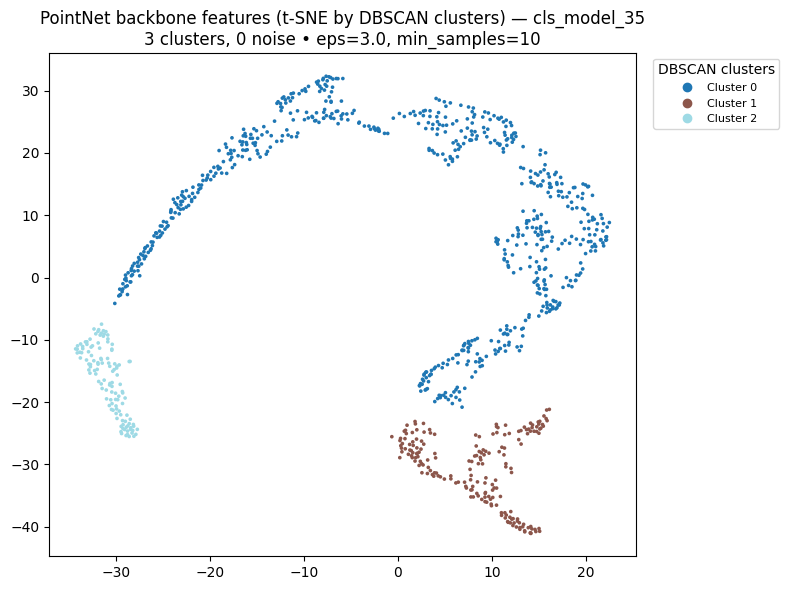

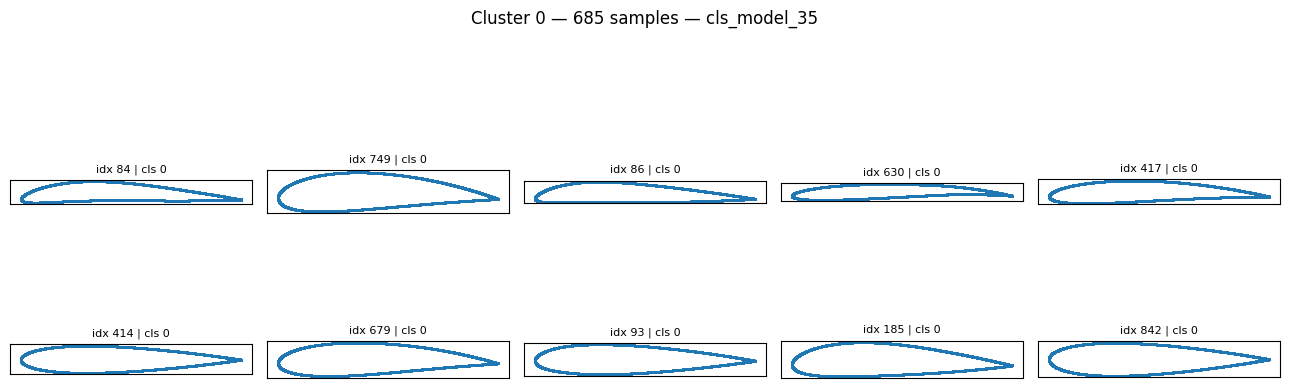

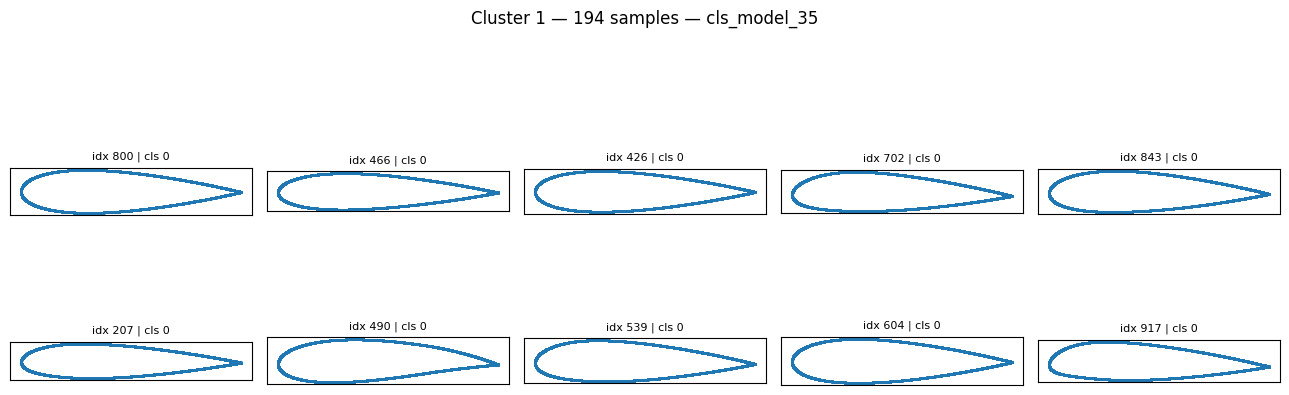

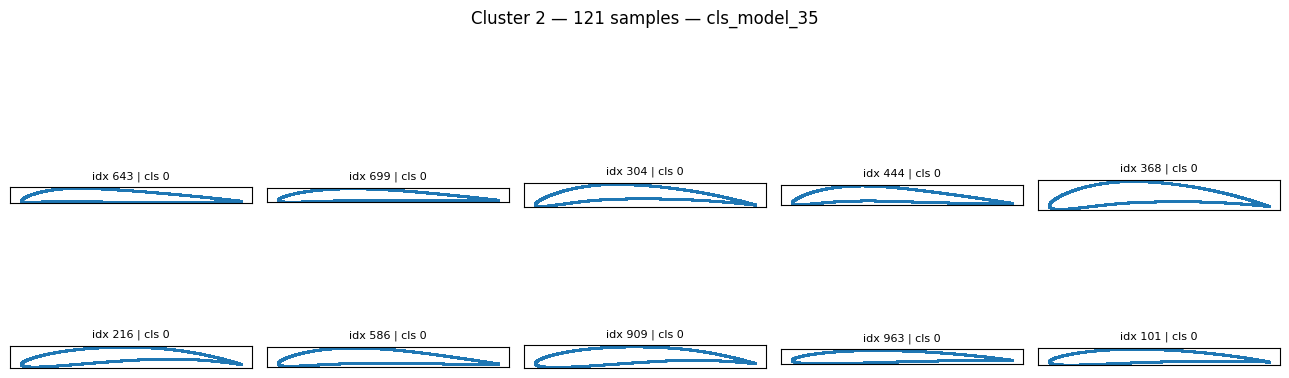

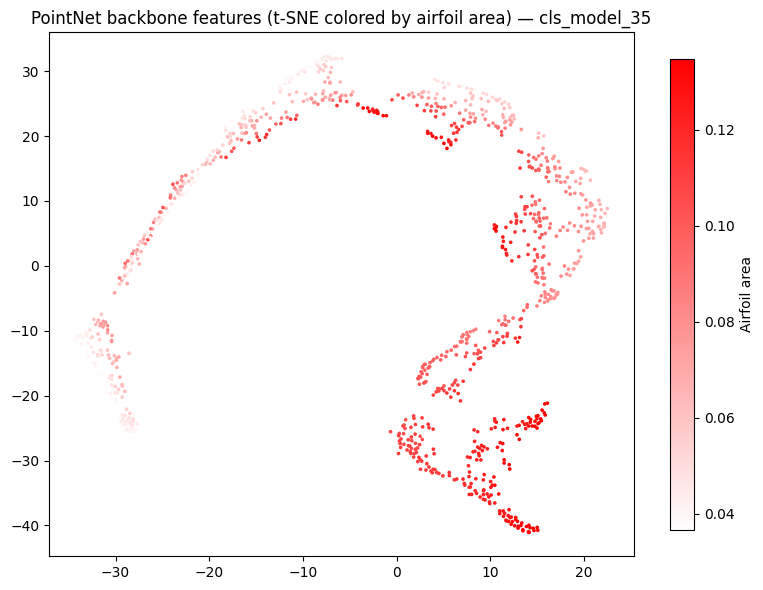

[cls_model_35] NACA kinds — 4-digit: 111, 5-digit: 889, unknown: 0


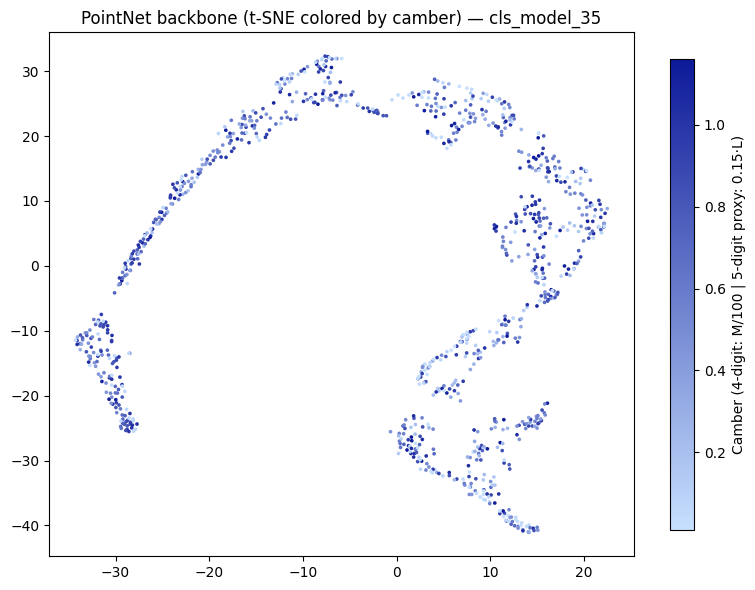

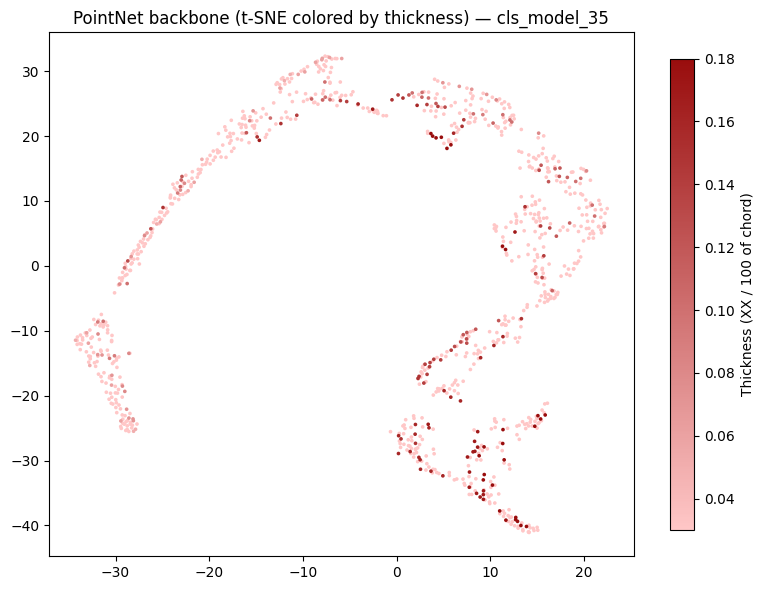

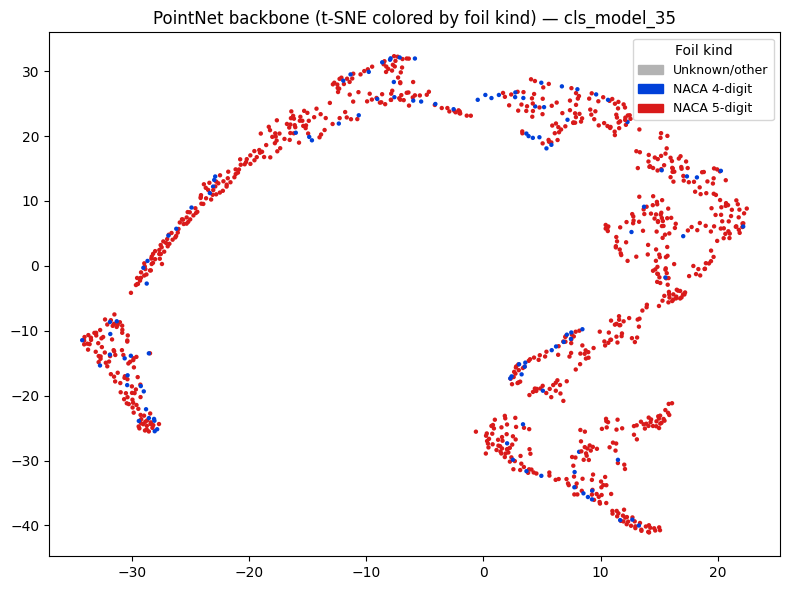

In [5]:
out35 = analyze_pointnet_backbone('trained_models/cls_focal_clr/cls_model_35.pth')

### cls_model_37

[cls_model_37] Model loaded from: trained_models/cls_focal_clr/cls_model_37.pth
[cls_model_37] Collected features: X=(1000, 1024), labels=(1000,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.983017
[t-SNE] KL divergence after 1000 iterations: 0.497530
[cls_model_37] t-SNE computed: X2=(1000, 2)
[cls_model_37] Detected 2 clusters (+ 0 noise points) with DBSCAN(eps=3.0, min_samples=10).


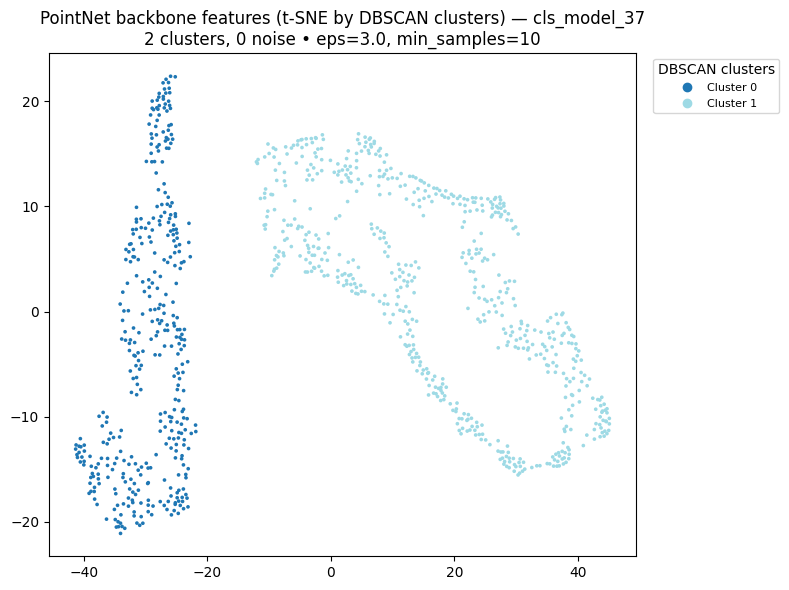

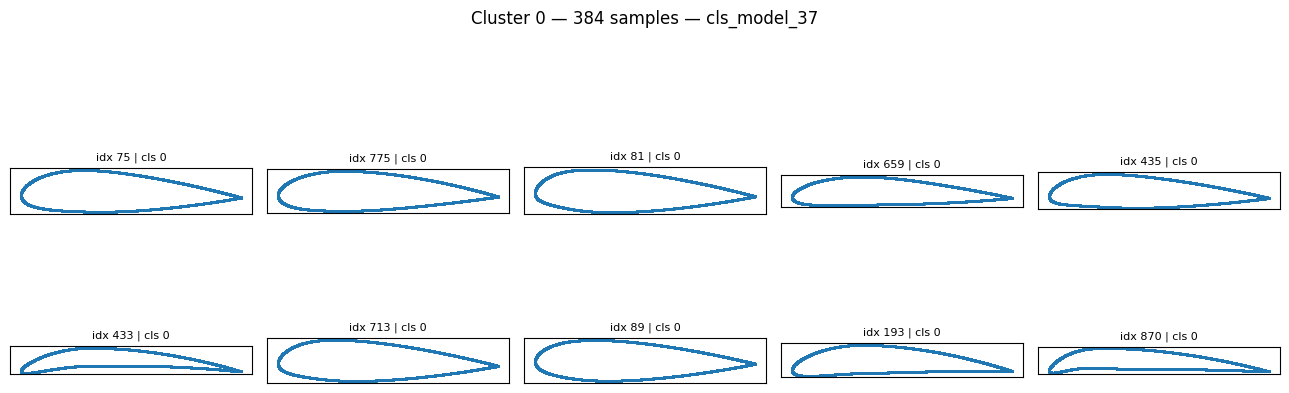

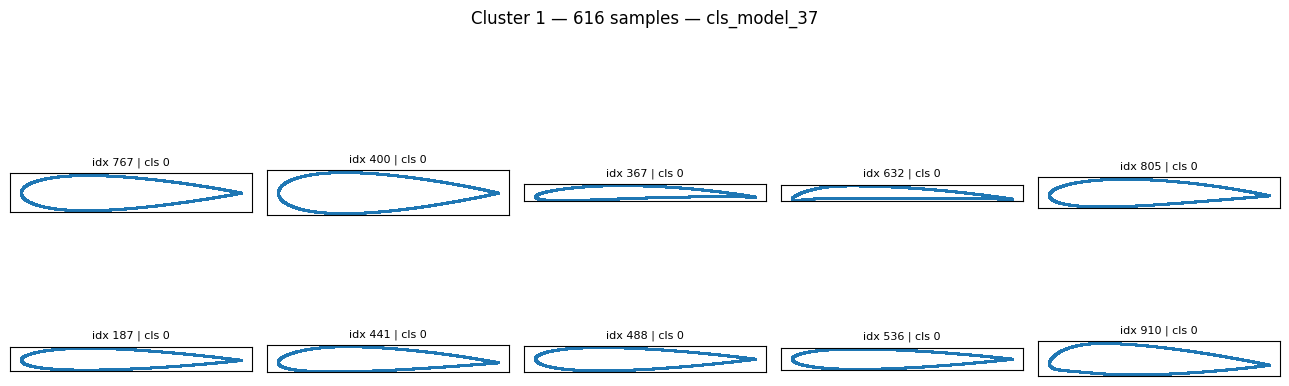

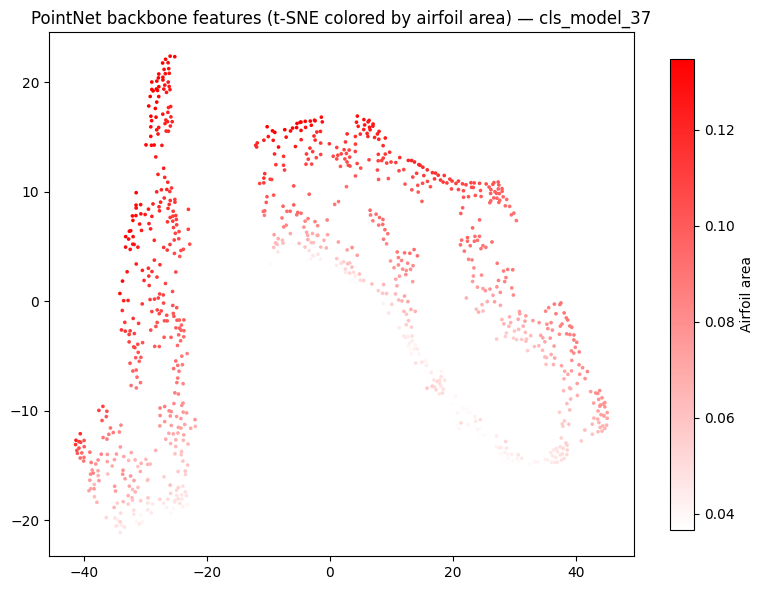

[cls_model_37] NACA kinds — 4-digit: 111, 5-digit: 889, unknown: 0


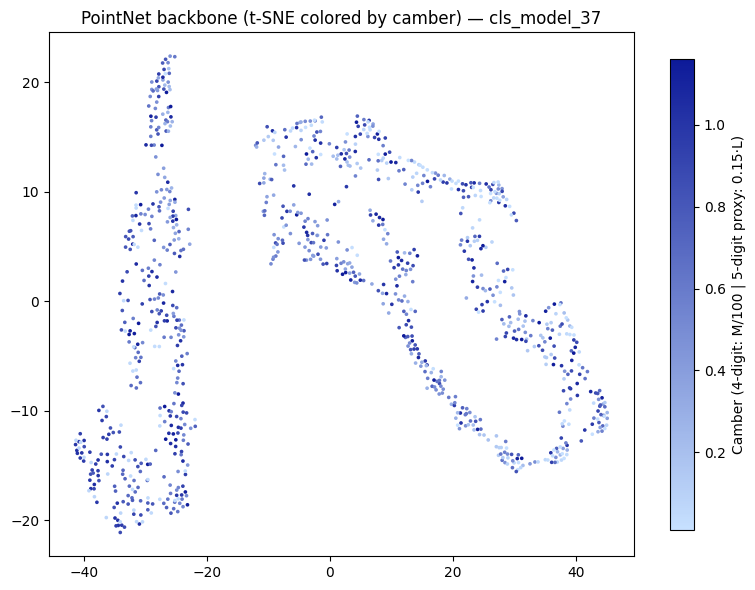

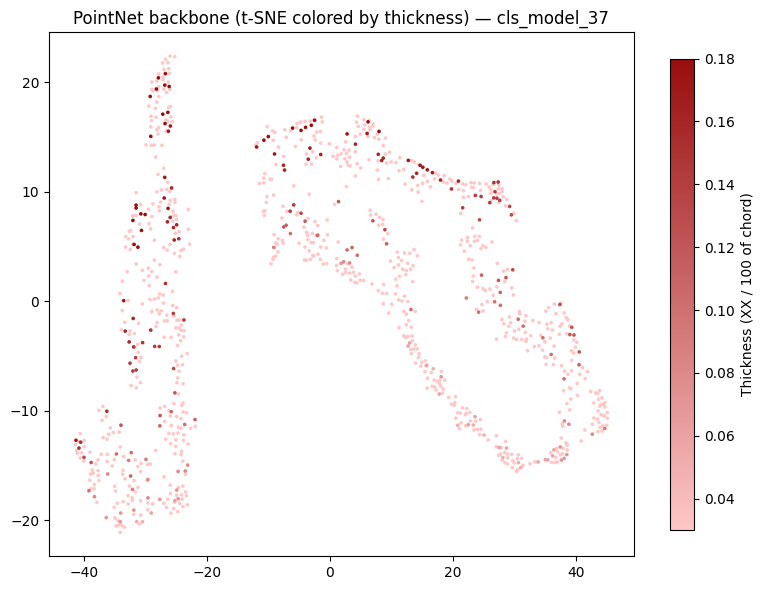

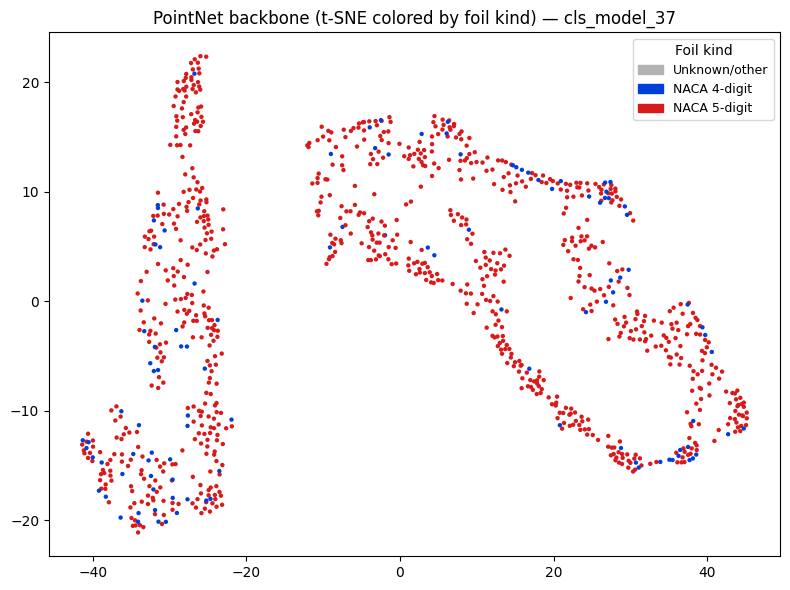

In [6]:
out37 = analyze_pointnet_backbone('trained_models/cls_focal_clr/cls_model_37.pth')

### cls_model_38

[cls_model_38] Model loaded from: trained_models/cls_focal_clr/cls_model_38.pth
[cls_model_38] Collected features: X=(1000, 1024), labels=(1000,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.005s...
[t-SNE] Computed neighbors for 1000 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000510
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.691818
[t-SNE] KL divergence after 1000 iterations: 0.499111
[cls_model_38] t-SNE computed: X2=(1000, 2)
[cls_model_38] Detected 2 clusters (+ 0 noise points) with DBSCAN(eps=3.0, min_samples=10).


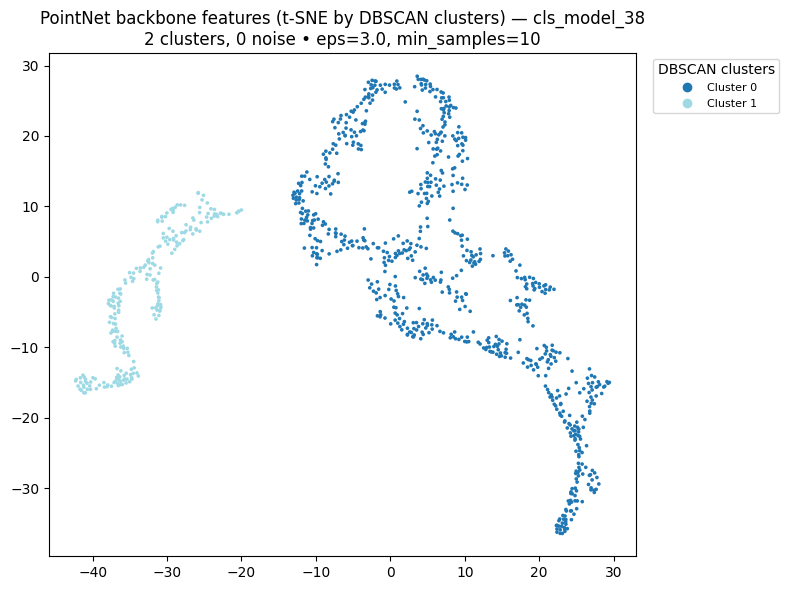

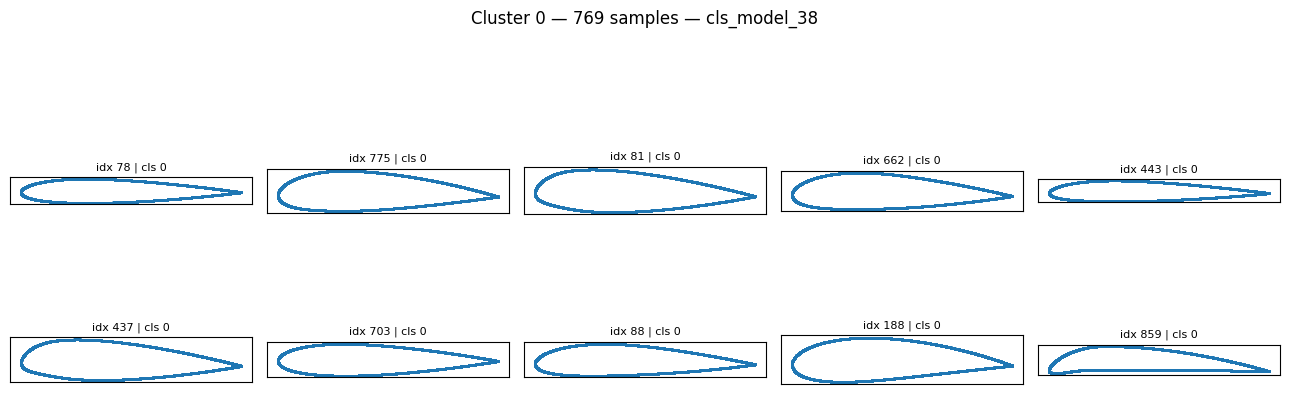

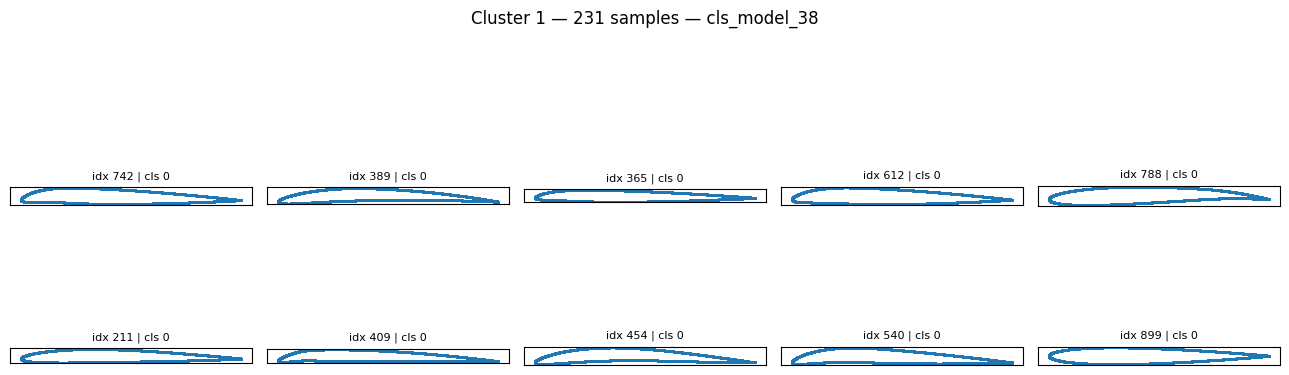

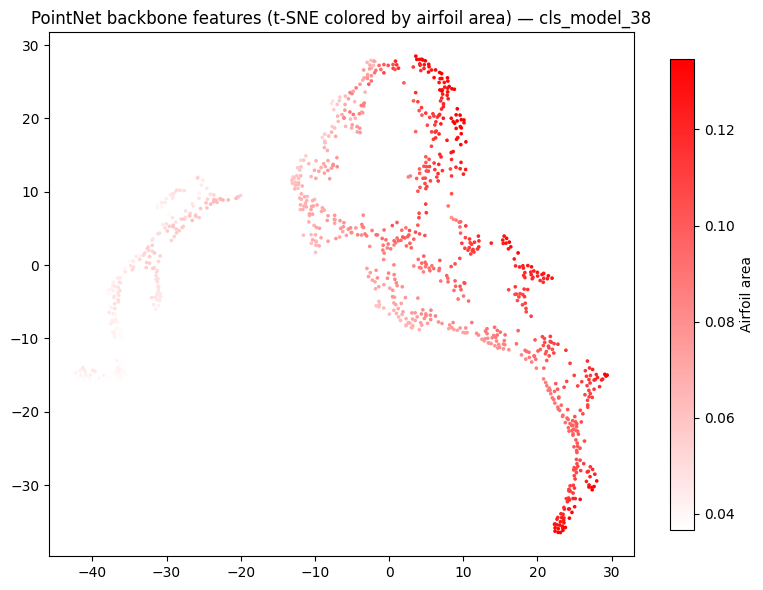

[cls_model_38] NACA kinds — 4-digit: 111, 5-digit: 889, unknown: 0


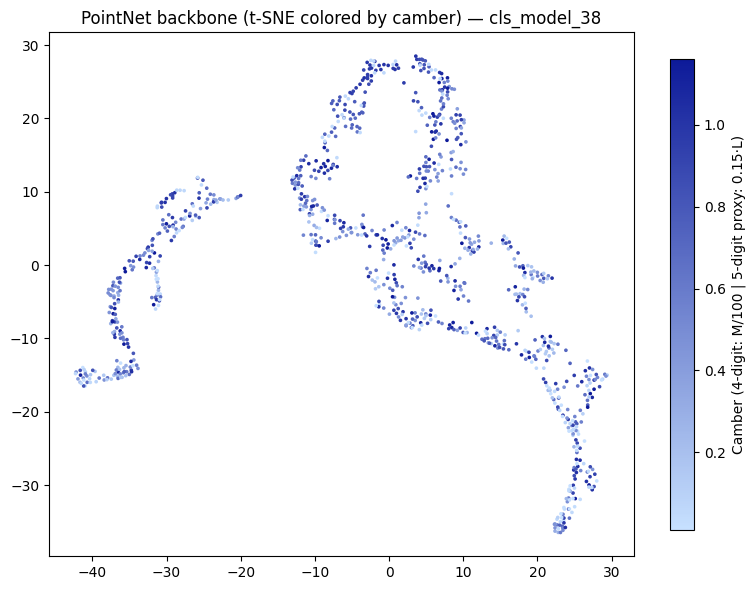

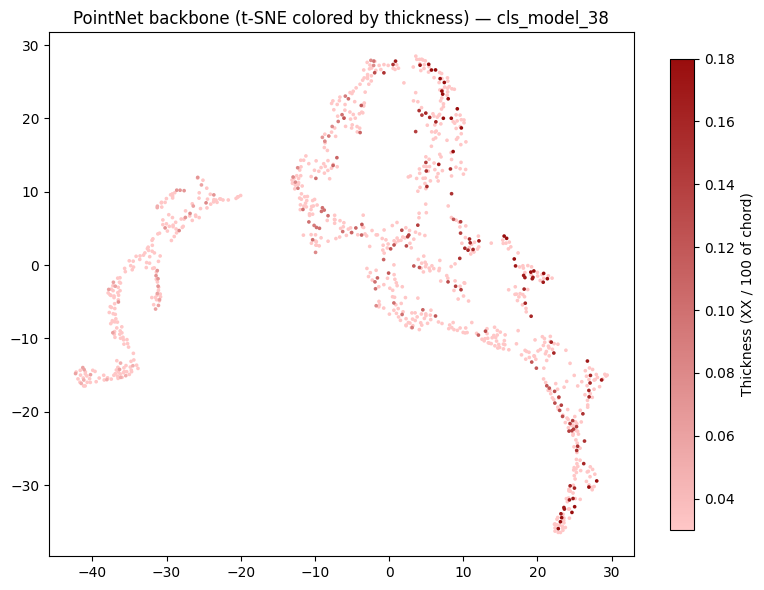

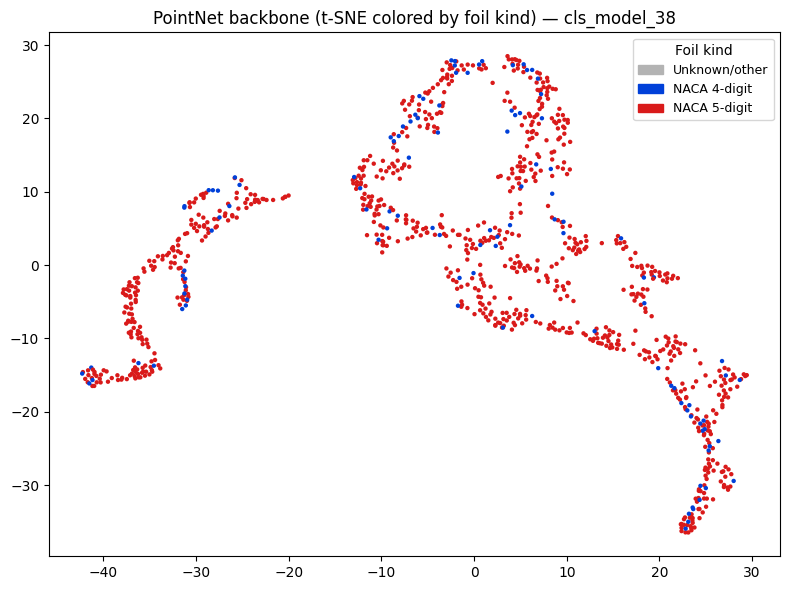

In [7]:
out38 = analyze_pointnet_backbone('trained_models/cls_focal_clr/cls_model_38.pth')

### cls_model_15

[cls_model_15] Model loaded from: trained_models/cls_focal/cls_model_15.pth
[cls_model_15] Collected features: X=(1000, 1024), labels=(1000,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.192505
[t-SNE] KL divergence after 1000 iterations: 0.634852
[cls_model_15] t-SNE computed: X2=(1000, 2)
[cls_model_15] Detected 2 clusters (+ 15 noise points) with DBSCAN(eps=3.0, min_samples=10).


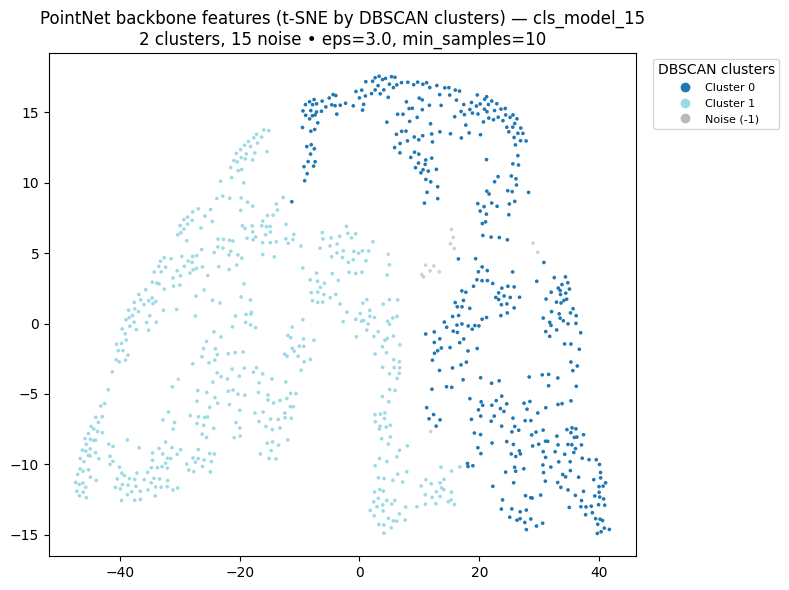

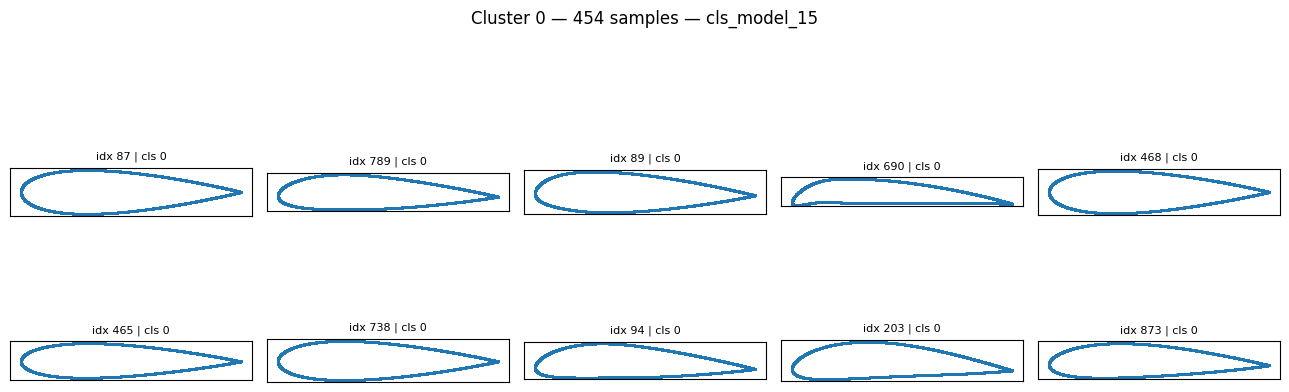

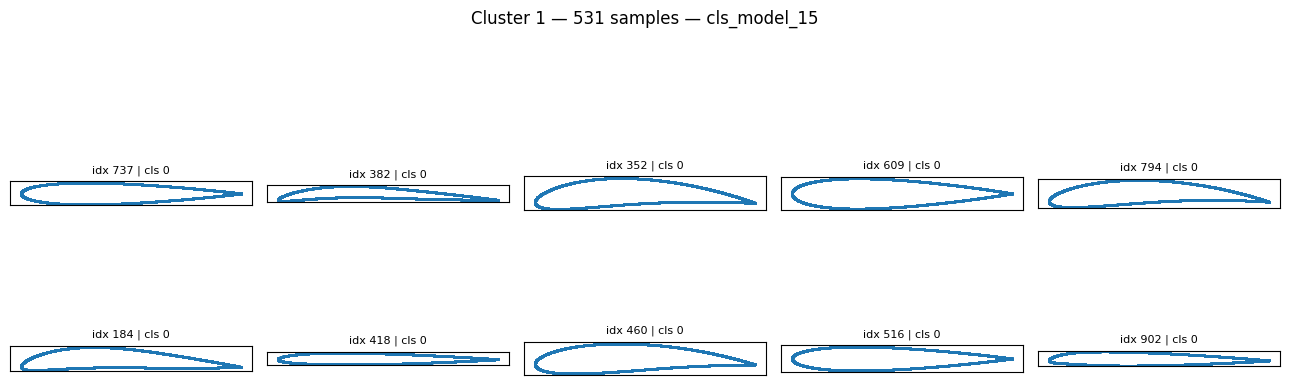

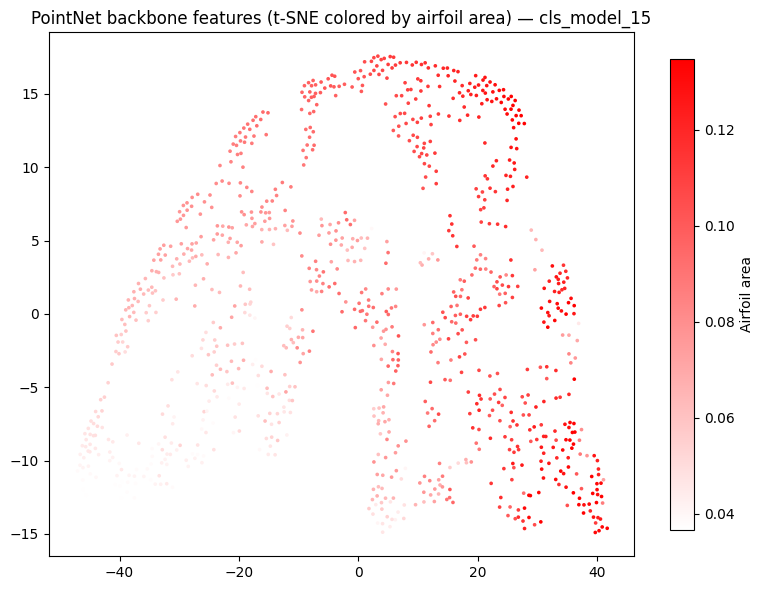

[cls_model_15] NACA kinds — 4-digit: 111, 5-digit: 889, unknown: 0


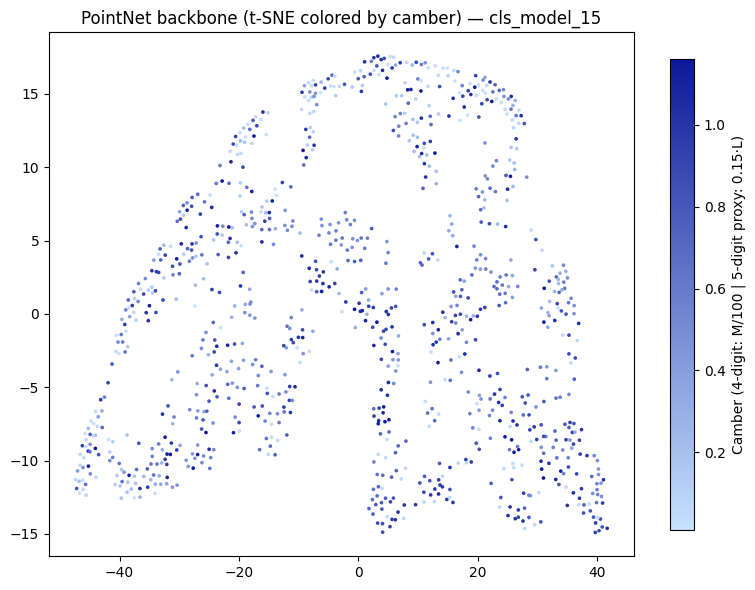

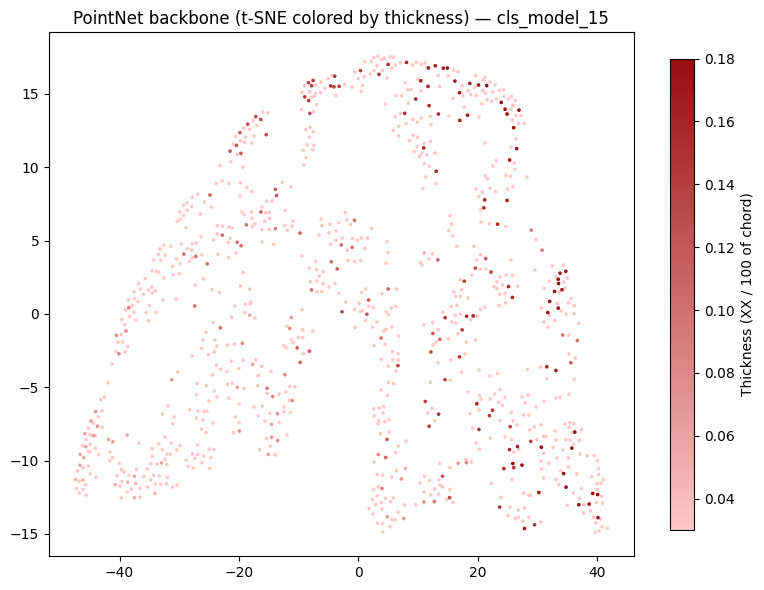

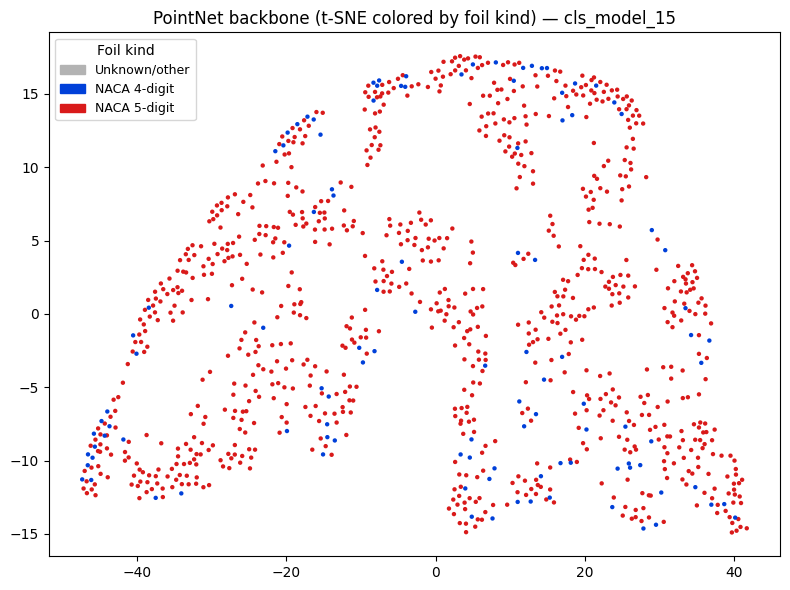

In [8]:
out15 = analyze_pointnet_backbone('trained_models/cls_focal/cls_model_15.pth')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.012s...
[t-SNE] Computed neighbors for 1000 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.028048
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.219383
[t-SNE] KL divergence after 1000 iterations: 2.661940
[Raw (x,y) t-SNE computed: X2_raw=(1000, 2)


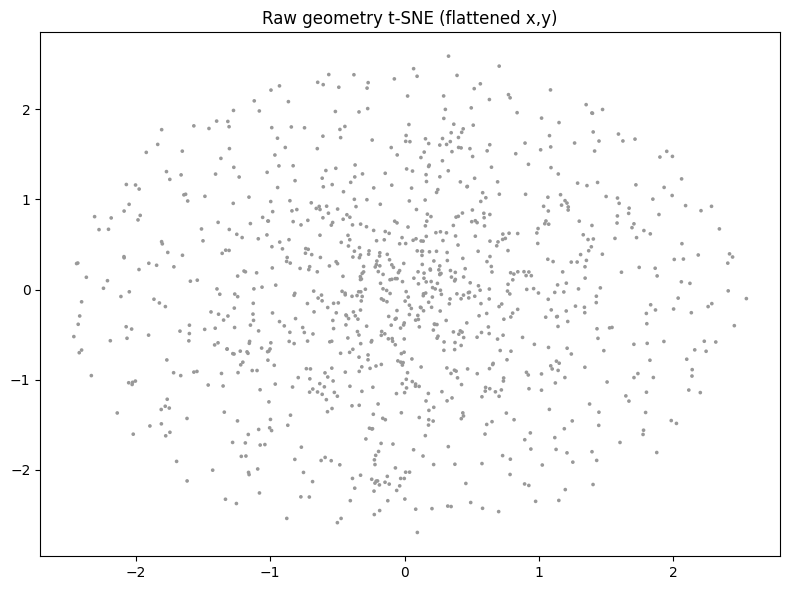

In [12]:
    # ------------------------------------------------------------------------------- t-SNE on raw (x,y) coordinates — no preprocessing
    N = len(test_dataset)
    NPTS = getattr(test_dataset, "npoints", None)

    # Build raw feature matrix by simple flattening of (x,y)
    raw_xy = np.empty((N, 2 * NPTS), dtype=np.float32)
    for i in range(N):
        pts, _ = test_dataset[i]                  # (NPTS, 3) tensor
        pts = np.asarray(pts)
        xy = pts[:, :2].reshape(-1)               # (2*NPTS,)
        raw_xy[i] = xy

    tsne_raw = TSNE(
        n_components=2,
        metric='cosine',
        init='pca', # t is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data)
        learning_rate='auto',
        perplexity=30, #  Consider selecting a value between 5 and 50
        verbose=1
    )
    X2_raw = tsne_raw.fit_transform(raw_xy)
    print(f"[Raw (x,y) t-SNE computed: X2_raw={X2_raw.shape}")

    # Plot (neutral)
    plt.figure(figsize=(8, 6))
    plt.scatter(X2_raw[:, 0], X2_raw[:, 1], s=7, color=(0.6, 0.6, 0.6), edgecolors='none')
    plt.title(f'Raw geometry t-SNE (flattened x,y)')
    plt.tight_layout()
    plt.show()
